# Automated Hydrograph Separation

## Preliminaries

### Load packages and data

In [121]:
import math
import numpy as np
import pandas as pd
from scipy.signal import lfilter
from scipy.stats import linregress
from datetime import timedelta
import matplotlib.pyplot as plt

df = pd.read_csv('dat/02ED014.csv') # headings: "Date,Flow,Flag"
dakm2 = 190. # https://wateroffice.ec.gc.ca/report/real_time_e.html?stn=02ED014
df.index = pd.to_datetime(df.Date)
df.drop(['Date','Flag'],axis=1, inplace=True) # drop unneeded columns
sval = 'Flow' # name of field above where streamflow is found
# print(df)

### Load functions

#### Recession Coefficient $k$
Automated extraction of the slowflow recession coefficient $k$ as in Linsley, Kohler, Paulhus (1975) pg.230

In [122]:
def recessionCoef(df):
    # collect recession dates
    d = df.to_dict('index')
    x, y = [], []
    for k,v in d.items():
        k1 = k + timedelta(days=1)
        if k1 in d: 
            if v[sval] > d[k1][sval]: 
                x.append(d[k1][sval])
                y.append(v[sval])   
    xt = x.copy()
    yt = y.copy()

    while True:
        lnreg = linregress(x,y)
        # print(lnreg)
        if lnreg.rvalue > 0.995: break
        rem = []
        for i in range(len(x)): 
            if y[i] > lnreg.slope*x[i]: rem.append(i)
        for i in sorted(rem, reverse = True):
            del x[i]
            del y[i]

    x2 = np.vstack([x, np.zeros(len(x))]).T # x needs to be a column vector instead of a 1D vector for this https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    a, _,_,_ = np.linalg.lstsq(x2, y, rcond=None) 
    # print(1/a[0]) # =k
    plt.scatter(xt, yt, alpha=0.5)    
    plt.plot(x2,a*x2,"r", alpha=0.75)
    plt.xlabel("$Q_t$")
    plt.ylabel("$Q_{t-1}$")
    plt.show()
    return 1/a[0]

#### Cecession Days $N$
Time (in days) after peak discharge from which quickflow ceases and total flow is entirely slowflow after Linsley, Kohler, Paulhus (1975).

In [123]:
def Ndays(careaKM2): return 0.827 * careaKM2 ** 0.2

#### Digital Filter
digital filter methods of automatic hydrograph separation:

$$b_t = \alpha b_{t-1} + \beta\left(q_t + \gamma q_{t-1}\right)$$

In [124]:
def digitalFilter(v, a1, b0, b1, nPasses=1):
    if nPasses <= 1: return np.minimum(v, lfilter([b0,b1], [1.0,-a1], v, axis=0))
    f = v
    for i in range(nPasses):
        if (i+1) % 2 == 0: f = np.flip(f)
        f = lfilter([b0,b1], [1.0,-a1], f, axis=0)
        if (i+1) % 2 == 0: f = np.flip(f)
        f = np.minimum(v, f)
    return np.minimum(v,f)

#### Moving Windows

##### set parameters

In [125]:
print(dakm2)
N = math.ceil(Ndays(dakm2))
print(N)

190.0
3


##### UKIH
The UKIH/Wallingford method (Institute of Hydrology, 1980) interpolates from minimum flow turning points. a.k.a. the "smoothed minima" technique.

In [126]:
def ukih(v):
    vvv = v
    for i in range(N):
        sukih = "o" + str(i)
        s = v.shift(-i, "D").rolling(str(N)+'D').min()
        s.rename(columns={sval: sukih}, inplace=True)

        vv = v.merge(s, on='Date')
        vv[sukih] = np.where(vv[sval]==vv[sukih], vv[sukih], np.NaN) # turning point
        vv[sukih].interpolate(method = 'linear', inplace = True) # interpolate
        vvv = vvv.merge(vv[sukih], on='Date')

    vvv['n'] = vvv.iloc[:,-N:].min(axis=1)
    vvv['x'] = vvv.iloc[:,-N:].max(axis=1)
    vvv['m'] = vvv.iloc[:,-N:].median(axis=1)

    vvv['sweepingMin'] = vvv[[sval,'n']].min(axis=1)
    vvv['sweepingMax'] = vvv[[sval,'x']].min(axis=1)
    vvv['sweepingMedian'] = vvv[[sval,'m']].min(axis=1)

    vvv.drop(vvv.iloc[:, 1:(N+4)], axis=1, inplace=True)

    # vvv[vvv.index.year>2015].plot(figsize=(20,10))
    # print(vvv)
    return vvv

##### HYSEP
Fixed interval, sliding interval, local minimum

In [127]:
twoNs =  2 * math.floor(N) + 1 # nearest odd integer
twoNsm1 = (twoNs-1)/2

def hysep(v):
    s = v.rolling(str(twoNs)+'D').min()[twoNs-1::twoNs]
    s.rename(columns={sval: 'FI'}, inplace=True)
    vv = v.merge(s, how='left', on='Date') 
    vv['FI'].fillna(method="bfill", inplace=True)

    s = v.rolling(str(twoNsm1)+'D').min()
    s.rename(columns={sval: 'SI'}, inplace=True)
    vv = vv.merge(s, how='left', on='Date')

    vv['LM'] = np.where(vv[sval]==vv['SI'], vv['SI'], np.NaN) # turning point
    vv['LM'].interpolate(method = 'linear', inplace = True) # interpolate
    vv['LM'] = vv[[sval,'LM']].min(axis=1)

    # print(vv)
    # vv[vv.index.year>2015].plot(figsize=(20,10))
    return vv


##### PART
The PART program is run three times with 3 different antecedent requirements (Rutledge, 1998):
> ...once considering the requirement of antecedent recession to be the largest integer that is less than the result of $[N=.827 A^{0.2}]$, and once for each of the next two larger integers.

> The antecedent recession requirement is met for the day in question if, for the part of the daily mean streamflow record that includes all days that precede the day in question by $N$ days or less, the streamflow on each of these days is greater than or equal to the streamflow on the day that follows it.

Then
> ground-water discharge is designated equal to streamflow as long as it is not followed by a daily decline of more than 0.1 log cycle.

> [determine], by linear interpolation the ground-water discharge on the remaining days.


not done:
> Are there any days when the base flow exceeds the streamflow? if yes then: locate any intervals where the value of ALLGW is continuously equal to 0 and where there is at least one day when base flow>streamflow. Find the day that exhibits the largest “log of base flow minus log of streamflow,” and reassign ALLGW=* on this day. 

> the program calculates the ground-water discharge for the exact result of equation 1 using the polynomial expression. Curvilinear interpolation gives the final estimate of base flow that corresponds to the precise result of equation 1.

    note that this final step is avoided as it is used in determining a long term average base discharge, and not a means of combining the 3 PART baseflow hydrographs into one.

In [128]:
def part(v, logdecline = .1):
    vvv = v.copy()
    for antereq in range(3):
        Npart = math.floor(N)+antereq # "largest integer that is less than the result of equation 1"
        arr = 'bf-'+str(Npart)
        vv = v.copy()

        s = v.rolling(str(Npart)+'D').min()
        s.rename(columns={sval: arr}, inplace=True)
        vv = vv.merge(s, how='left', on='Date')
        vv[arr][vv[sval] > vv[arr]] = np.NaN

        vv['o1'] = np.log10(vv[sval])
        vv['o2'] = -vv['o1'].diff()
        vv[arr][vv['o2'] <0] = np.NaN
        vv[arr][vv['o2'] > logdecline] = np.NaN

        vv[arr].interpolate(method = 'linear', inplace = True) # interpolate
        
        vv[arr] = vv[[sval,arr]].min(axis=1)

        # print(vv)
        # vv[vv.index.year>2015].plot(figsize=(20,10))
        vvv = vvv.merge(vv[arr], how='left', on='Date')

    # print(vvv)
    # vvv[vvv.index.year>2015].plot(figsize=(20,10))
    return vvv
    

##### Clarifica
the "Clarifica" technique (a.k.a. Graham method); named in (Clarifica, 2002) as a "forward and backward-step averaging approach" based on a 5-day average running, 6-day minimum rolling filter.

In [129]:
def clarifica(v):
    s = v.rolling('6D').min() # 6-day running minimum discharge   
    s = s.rolling('5D').mean().shift(-1, "D") # 5-day running average (3 days previous, 1 day ahead)
    return np.minimum(v,s)

### Run Algorithms

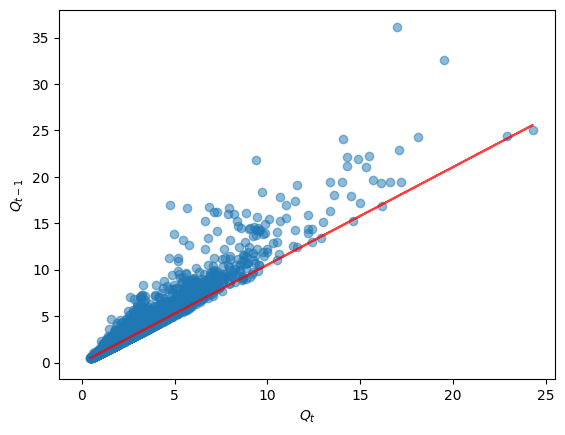

recession coefficient 0.9497672421764295


In [130]:
dfo = df.copy()
k = recessionCoef(df)
print("recession coefficient {}".format(k))

#### 6 Digital Filters:

In [131]:
# Lyne, V. and M. Hollick, 1979. Stochastic time-variable rainfall-runoff modelling. Hydrology and Water Resources Symposium, Institution of Engineers Australia, Perth: 89-92.
#  k <- 0.925 # Ranges from 0.9 to 0.95 (Nathan and McMahon, 1990).  
a = k
b = (1-k)/2
c = (1-k)/2
nPass = 3 #  3 passes commonly used (Chapman, 1999)
dfo['LynnHollick'] = digitalFilter(df[[sval]].to_numpy(),a,b,c,nPass)

# Chapman, T.G., 1991. Comment on the evaluation of automated techniques for base flow and recession analyses, by R.J. Nathan and T.A. McMahon. Water Resource Research 27(7): 1783-1784
a = (3*k-1)/(3-k)
b = (1-k)/(3-k)
c = (1-k)/(3-k)
dfo['Chapman91'] = digitalFilter(df[[sval]].to_numpy(),a,b,c,1)

# Chapman, T.G. and A.I. Maxwell, 1996. Baseflow separation - comparison of numerical methods with tracer experiments. Institute Engineers Australia National Conference. Publ. 96/05, 539-545.
a = k/(2-k)
b = (1-k)/(2-k)
c = 0
dfo['ChapmanMaxwell'] = digitalFilter(df[[sval]].to_numpy(),a,b,c,1)

# Boughton & Eckhardt
# Boughton, W.C., 1993. A hydrograph-based model for estimating the water yield of ungauged catchments. Hydrology and Water Resources Symposium, Institution of Engineers Australia, Newcastle: 317-324.
# Eckhardt, K., 2005. How to construct recursive digital filters for baseflow separation. Hydrological Processes 19, 507-515.
bfimax = 0.8
c = (1-k)*bfimax/(1-bfimax)
a = k/(1+c)
b = c/(1+c)
c = 0
dfo['BoughtonEckhardt'] = digitalFilter(df[[sval]].to_numpy(),a,b,c,1)

# Jakeman, A.J. and Hornberger G.M., 1993. How much complexity is warranted in a rainfall-runoff model? Water Resources Research 29: 2637-2649.
a = k
c = (1-k)*bfimax/(1-bfimax)
a = a/(1+c)
b = c/(1+c)
c = b * -math.exp(-1/k)
dfo['JakemanHornberger'] = digitalFilter(df[[sval]].to_numpy(),a,b,c,1)

# Tularam, A.G., Ilahee, M., 2008. Exponential Smoothing Method of Base Flow Separation and its Impact on Continuous Loss Estimates. American Journal of Environmental Sciences 4(2):136-144.
a = k
b = 1-a
c = 0
dfo['TularamIlahee'] = digitalFilter(df[[sval]].to_numpy(),a,b,c,1)


#### Moving Window

In [132]:
# Institute of Hydrology, 1980. Low Flow Studies report. Wallingford, UK.
# Piggott, A.R., S. Moin, C. Southam, 2005. A revised approach to the UKIH method for the calculation of baseflow. Hydrological Sciences Journal 50(5): 911-920.
uk = ukih(df)
dfo['sweepingMin'] = uk['sweepingMin']
dfo['sweepingMax'] = uk['sweepingMax']
dfo['sweepingMedian'] = uk['sweepingMedian']

In [133]:
# Sloto, R.A. and M.Y. Crouse, 1996. HYSEP: A Computer Program for Streamflow Hydrograph Separation and Analysis U.S. Geological Survey Water-Resources Investigations Report 96-4040.
sc = hysep(df)
dfo['fixedInterval'] = sc['FI']
dfo['slidingInterval'] = sc['SI']
dfo['localMinimum'] = sc['LM']

In [134]:
# Rutledge, A.T., 1998. Computer Programs for Describing the Recession of Ground-Water Discharge and for Estimating Mean Ground-Water Recharge and Discharge from Streamflow Records-Update, Water-Resources Investigation Report 98-4148.
pt = part(df.copy())
dfo['part1'] = pt.iloc[:, -3]
dfo['part2'] = pt.iloc[:, -2]
dfo['part3'] = pt.iloc[:, -1]

In [135]:
# Clarifica Inc., 2002. Water Budget in Urbanizing Watersheds: Duffins Creek Watershed. Report prepared for the Toronto and Region Conservation Authority.
dfo['Clarifica'] = clarifica(df)

C:\Users\mason\AppData\Local\Temp\ipykernel_6804\2836607824.py:4: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return np.minimum(v,s)


### Print/show/save results

<AxesSubplot: xlabel='Date'>

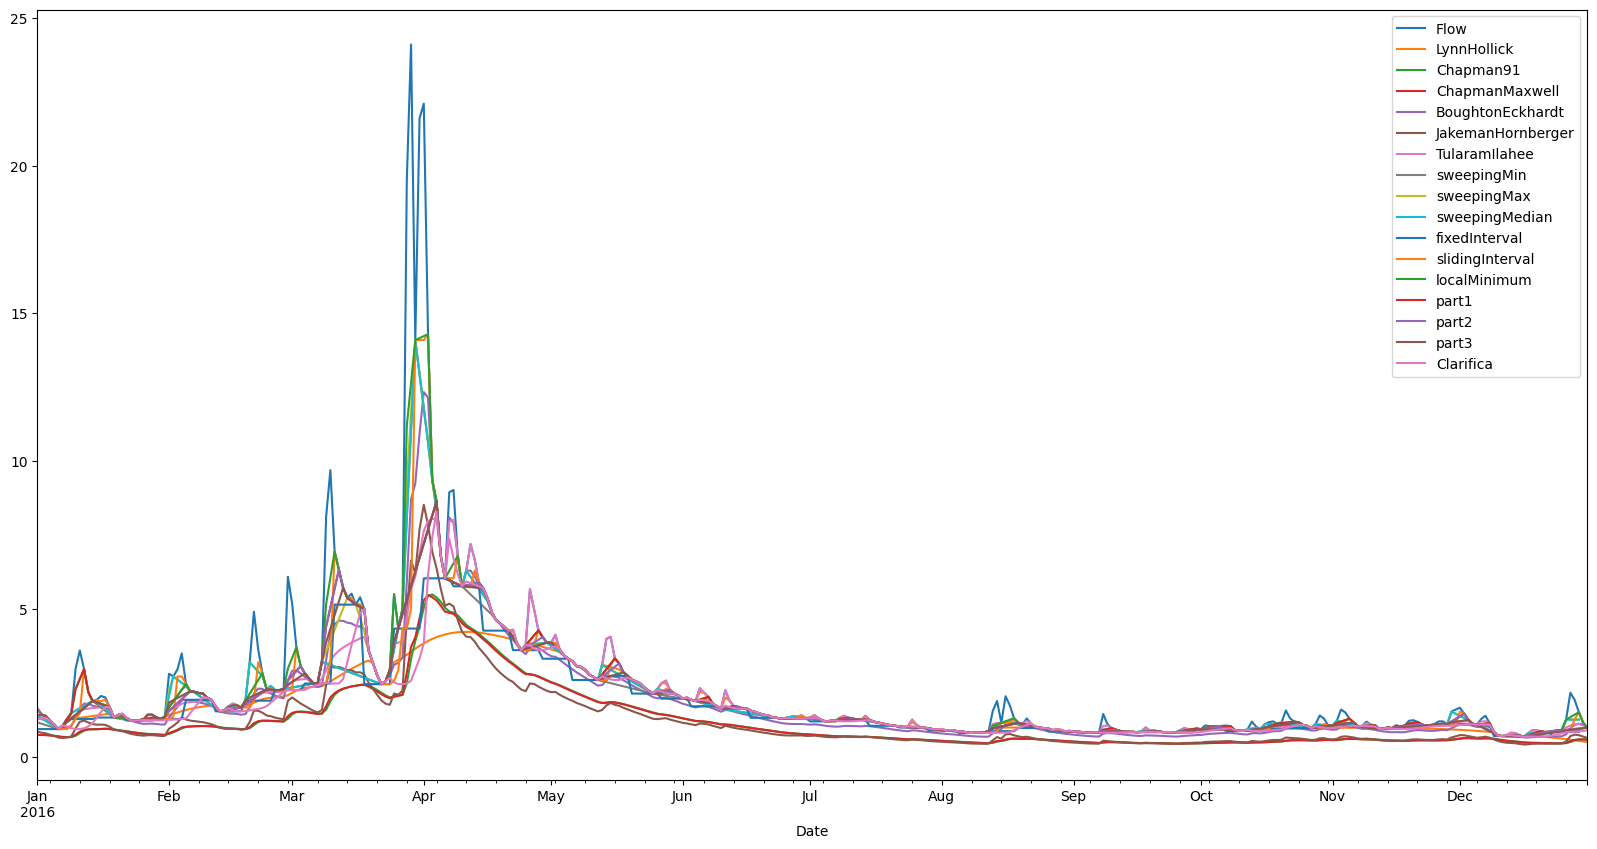

In [136]:
# dfo.to_csv('dat/out.csv') # save results here:
dfo[dfo.index.year>2015].plot(figsize=(20,10))

<AxesSubplot: xlabel='Date'>

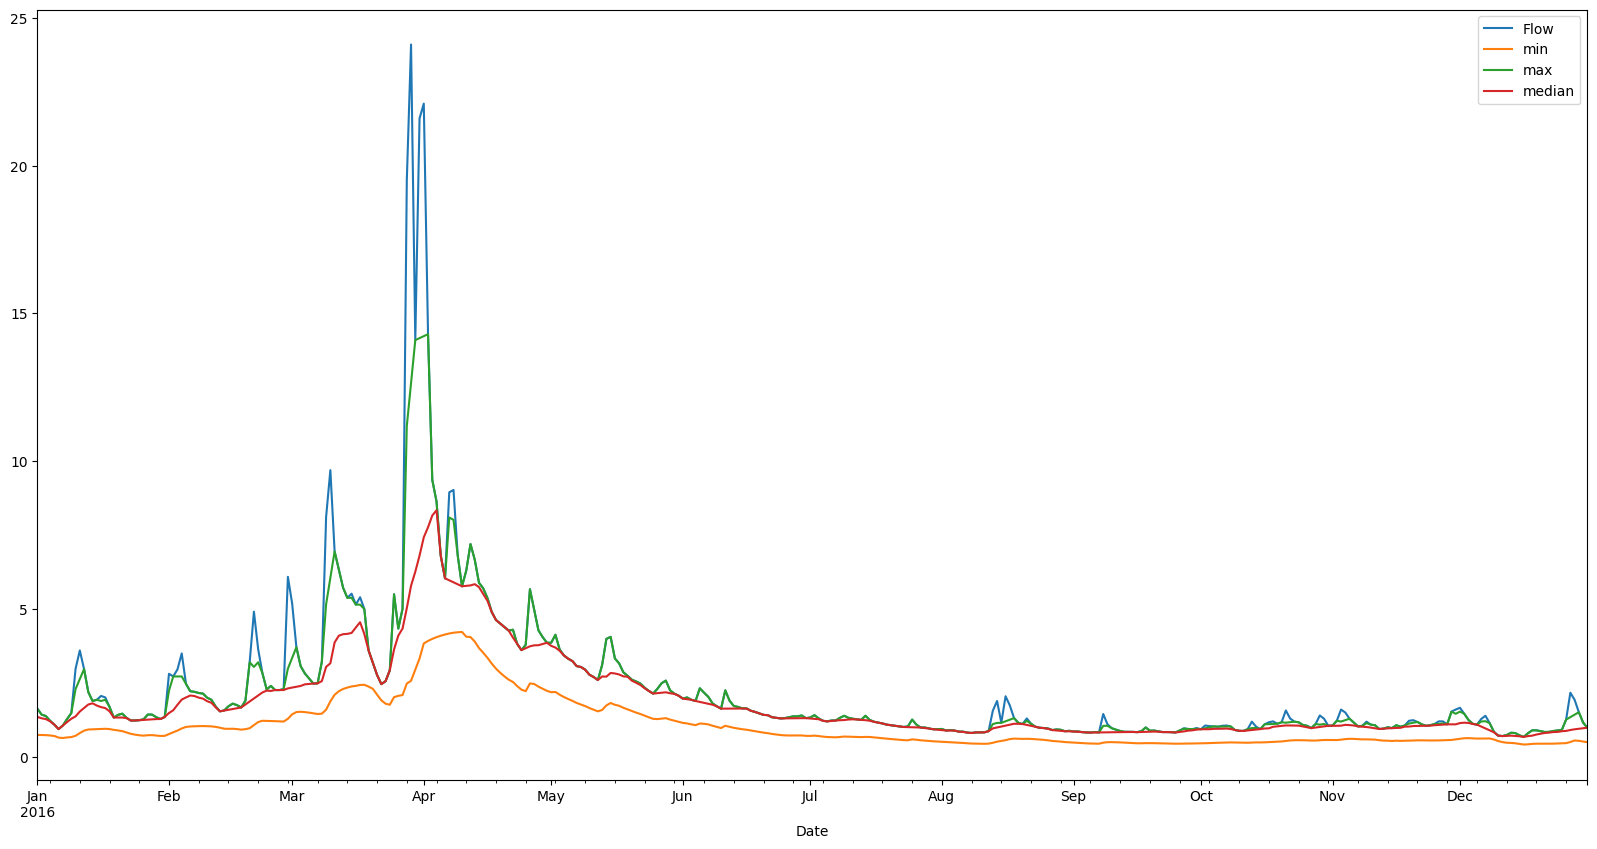

In [137]:
nc = len(dfo.columns)
dfo['min'] = dfo.iloc[:,1:nc].min(axis=1)
dfo['max'] = dfo.iloc[:,1:nc].max(axis=1)
dfo['median'] = dfo.iloc[:,1:nc].median(axis=1)
dfo[dfo.index.year>2015].iloc[ :, [0] + [-3,-2,-1]].plot(figsize=(20,10))

## References

Boughton, W.C., 1993. A hydrograph-based model for estimating the water yield of ungauged catchments. Hydrology and Water Resources Symposium, Institution of Engineers Australia, Newcastle: 317-324.

Chapman, T.G., 1991. Comment on the evaluation of automated techniques for base flow and recession analyses, by R.J. Nathan and T.A. McMahon. Water Resource Research 27

Chapman, T.G. and A.I. Maxwell, 1996. Baseflow separation - comparison of numerical methods with tracer experiments. Institute Engineers Australia National Conference. Publ. 96/05, 539-545.

Clarifica Inc., 2002. Water Budget in Urbanizing Watersheds: Duffins Creek Watershed. Report prepared for the Toronto and Region Conservation Authority.

Eckhardt, K., 2005. How to construct recursive digital filters for baseflow separation. Hydrological Processes 19, 507-515.

Institute of Hydrology, 1980. Low Flow Studies report. Wallingford, UK.

Jakeman, A.J. and Hornberger G.M., 1993. How much complexity is warranted in a rainfall-runoff model? Water Resources Research 29: 2637-2649.

Linsley, R.K., M.A. Kohler, J.L.H. Paulhus, 1975. Hydrology for Engineers 2nd ed. McGraw-Hill. 482pp.

Lyne, V. and M. Hollick, 1979. Stochastic time-variable rainfall-runoff modelling. Hydrology and Water Resources Symposium, Institution of Engineers Australia, Perth: 89-92.

Piggott, A.R., S. Moin, C. Southam, 2005. A revised approach to the UKIH method for the calculation of baseflow. Hydrological Sciences Journal 50(5): 911-920.

Rutledge, A.T., 1998. Computer Programs for Describing the Recession of Ground-Water Discharge and for Estimating Mean Ground-Water Recharge and Discharge from Streamflow Records-Update, Water-Resources Investigation Report 98-4148.

Sloto, R.A. and M.Y. Crouse, 1996. HYSEP: A Computer Program for Streamflow Hydrograph Separation and Analysis U.S. Geological Survey Water-Resources Investigations Report 96-4040.

Tularam, A.G., Ilahee, M., 2008. Exponential Smoothing Method of Base Flow Separation and its Impact on Continuous Loss Estimates. American Journal of Environmental Sciences 4(2):136-144.